# Extraction des features des images

## 1. Préparation

In [9]:
import os
from PIL import Image, UnidentifiedImageError
from PIL.TiffTags import TAGS
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter, laplace
from scipy.stats import entropy as scipy_entropy
import cv2
import time
from matplotlib import pyplot as plt

from joblib import Parallel, delayed

import sys
from pathlib import Path

project_root = Path().resolve().parent
if not project_root in [Path(p).resolve() for p in sys.path]:
    sys.path.append(str(project_root))

from src import PATHS

df = pd.read_parquet(PATHS.metadata / "df_filepaths.parquet")
file_paths = PATHS.data / df.rvl_image_path
assert file_paths.iloc[0].exists()

## 2. Ecriture de fonctions pour extraire:
- la largeur
- la netteté (avec la variance du laplacien, normalisee par le nombre de pixels de l'image)
- le bruit (on lisse l'image avec un blur gaussien et on compare à l'image initiale)
- le ratio de pixels blancs (valeur > 200)
- le ratio de pixels noirs (valeur < 50)
- la taille des bords/marges de façon à pouvoir les retirer lors du preprocessing
- le nombre de lignes

In [10]:
def nettete(img):
    """
    Mesure la netteté via la variance du Laplacien, normalisée par le nombre de pixels.
    """
    try:
        lap = laplace(img)
        return np.var(lap) / img.size
    except Exception as e:
        print("Erreur dans nettete():", e)
        return None

def bruit(img):
    """
    Estime le bruit en comparant l'image à une version lissée avec un filtre gaussien.
    """
    sigma=1.0
    if img is None:
        raise ValueError(f"Impossible de lire l'image : {file_path}")
    img = img.astype(np.float32)
    smoothed = cv2.GaussianBlur(img, (0, 0), sigma)
    noise = img - smoothed
    return np.std(noise)

def ratio_b(img):
    """
    Retourne le ratio de pixels dont la valeur est supérieure à 200 (pixels blancs).
    """
    white_pixels = np.sum(img > 200)
    return white_pixels / img.size

def ratio_n(img):
    """
    Retourne le ratio de pixels dont la valeur est inférieure à 50 (pixels noirs).
    """
    black_pixels = np.sum(img < 50)
    return black_pixels / img.size

def entropy(img):
    """
    Calcule l'entropie d'une image en niveaux de gris à partir d'un fichier image.

    L'entropie est une mesure statistique qui quantifie la quantité d'information
    ou la complexité présente dans l'image. Plus l'entropie est élevée, plus
    l'image contient de détails ou de variations.

    Cette fonction lit l'image en utilisant OpenCV en mode niveaux de gris,
    calcule son histogramme normalisé des intensités de pixel, puis calcule
    l'entropie de cette distribution.

    Paramètres:
    -----------
    file_path : str
        Chemin vers le fichier image à analyser.
    resize_max_dim : int ou None, optionnel (par défaut None)
        Si spécifié, redimensionne l'image pour que la plus grande dimension
        soit égale à cette valeur, afin d'accélérer le calcul sur les grandes images.

    Retour:
    --------
    float
        Valeur de l'entropie de l'image (en nats).

    """
    if img is None:
        raise ValueError(f"Impossible de lire l'image : {file_path}")
    # Pas besoin de .load(), img est déjà un np.array
    hist, _ = np.histogram(img, bins=256, range=(0, 255), density=True)
    hist = hist[hist > 0]
    return scipy_entropy(hist)

def compression(img):
    """
    Récupère les informations de compression d'une image.

    Retourne :
    - Le type de compression utilisé dans le fichier (ex: 'packbits', 'jpeg', None, etc.)
    - Un ratio de compression approximatif (taille fichier / taille brute image)

    Parameters
    ----------
    file_path : str
        Chemin vers le fichier image.

    Returns
    -------
    tuple (str or None, float)
        (compression_type, compression_ratio)
    """
    compression_type = img.info.get('compression', None)
    width, height = img.size
    channels = len(img.getbands())
    # Hypothèse : 1 octet par canal (ex: mode 'L', 'RGB')
    depth_bytes = 1
    uncompressed_size = width * height * channels * depth_bytes

    file_size = os.path.getsize(file_path)
    compression_ratio = file_size / uncompressed_size if uncompressed_size > 0 else None

    return compression_type, compression_ratio


def resolution(img):
    #Extrait la résolution (DPI) horizontale et verticale d'une image.
    #Retourne (dpi_x, dpi_y) si disponible, sinon (np.nan, np.nan).
    
    try:
        dpi = img.info.get('dpi')
        if isinstance(dpi, (tuple, list)) and len(dpi) == 2:
            return dpi[0], dpi[1]
    except Exception as e:
        pass  # ou log l'erreur si besoin

    return np.nan, np.nan


In [11]:
def marges(img):
    """
    Détecte les marges haut, bas, gauche, droite d'une image TIFF en mode L.

    Params:
        image_path (str): chemin vers l'image .tiff
    Returns:
        top, bottom, left, right: tailles des marges en pixels
    """
    # 1. récupérer l'image
    img_np = np.array(img)
    height, width = img_np.shape
    
    # Filtre médian pour réduire le bruit ponctuel
    denoised = cv2.medianBlur(img_np, ksize=5)  # ksize impair, typiquement 3 ou 5

    # Floutage gaussien pour lisser avant seuillage
    blurred = cv2.GaussianBlur(denoised, (5, 5), 0)

    # Binarisation adaptative sur image débruitée
    binary = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=25,
        C=15
    )
    
    # 4. Projections
    rows_sum = binary.sum(axis=1)
    cols_sum = binary.sum(axis=0)
    # Filtrer les lignes à analyser
    top_bottom_ignore = 30
    side_ignore=50 
    # On enlève les bords parce qu'il peut y avoir des traits noirs dus à un scan de mauvaise qualité
    valid_rows = rows_sum[top_bottom_ignore:height - top_bottom_ignore]
    valid_cols = cols_sum[side_ignore:width - side_ignore]

    if valid_rows.max() == 0 or valid_cols.max() == 0:
        # Aucun texte détecté
        return {'top': 0, 'bottom': height, 'left': 0, 'right': width}

    # Marges haut/bas (avec décalage)
    top = np.argmax(valid_rows > 0) + top_bottom_ignore
    bottom = height - top_bottom_ignore - np.argmax(valid_rows[::-1] > 0)

    # Marges gauche/droite (avec décalage)
    left = np.argmax(valid_cols > 0) + side_ignore
    right = width - side_ignore - np.argmax(valid_cols[::-1] > 0)

    return top, bottom,  left, right

In [12]:
#pour récupérer le nombre de lignes
def merge_close_lines(lines, min_distance):
    """
    Fusionne les lignes trop proches les unes des autres.
    """
    if not lines:
        return []

    merged = [lines[0]]
    
    for start, end in lines[1:]:
        prev_start, prev_end = merged[-1]
        if start - prev_end < min_distance:
            # Fusionner avec la précédente
            merged[-1] = (prev_start, end)
        else:
            merged.append((start, end))
    return merged


def show_detection_nb_lignes(img, show=True, debug=False):
    """
    Détecte et (optionnellement) affiche les lignes de texte dans une image en niveaux de gris.

    Params:
        img (ndarray): Image (déjà rognée) en niveaux de gris.
        show (bool): Affiche l’image avec les lignes détectées si True.
        debug (bool): Affiche aussi le profil de projection si True.

    Returns:
        lines (List of tuples): liste de tuples (start_row, end_row) pour chaque ligne détectée.
    """
    img_np = np.array(img)

    # Binarisation (texte noir sur fond blanc)
    _, binary = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = 255 - binary  # Texte = 255 maintenant

    # Morphologie verticale
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    eroded = cv2.erode(binary_inv, kernel, iterations=1)

    # Profil de projection verticale
    projection = np.sum(eroded // 255, axis=1)

    # Seuil basé sur le percentile 95
    max_proj = np.percentile(projection, 95)
    threshold = max_proj * 0.25

    # Détection des lignes
    lines = []
    in_line = False
    start = 0

    for i, val in enumerate(projection):
        if val > threshold:
            if not in_line:
                start = i
                in_line = True
        else:
            if in_line:
                end = i
                lines.append((start, end))
                in_line = False
    if in_line:
        lines.append((start, len(projection)))

    # Fusionner les lignes trop proches
    lines = merge_close_lines(lines, min_distance=4)

    # Affichage (si demandé)
    if show:
        fig, ax = plt.subplots(figsize=(8, 10))
        ax.imshow(img_np, cmap='gray')
        for start, end in lines:
            rect = plt.Rectangle((0, start), img_np.shape[1], end - start,
                                 linewidth=1, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        ax.set_title(f"Lignes détectées : {len(lines)}")
        ax.axis('off')
        plt.show()

    if debug:
        plt.figure(figsize=(8, 2))
        plt.plot(projection)
        plt.axhline(y=threshold, color='red', linestyle='--')
        plt.title("Projection verticale des pixels noirs (profil)")
        plt.show()

    return lines


In [13]:
def show_detection_nb_colonnes(img, show=True, debug=False):
    """
    Détecte et (optionnellement) affiche les colonnes de texte dans une image (numpy, niveaux de gris).

    Params:
        img (ndarray): Image en niveaux de gris (déjà rognée).
        show (bool): Affiche l’image avec les colonnes détectées si True.
        debug (bool): Affiche le profil de projection horizontal si True.

    Returns:
        columns (List of tuples): liste de tuples (start_col, end_col) pour chaque colonne détectée.
    """
    img_np = np.array(img)

    # Binarisation
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_eq = clahe.apply(img_np)
    _, binary = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = 255 - binary  # texte = 255

    # Morphologie horizontale pour séparer les colonnes (éventuellement)
    kernel_width = max(10, img_eq.shape[1] // 100)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, 1))
    eroded = cv2.erode(binary_inv, kernel, iterations=1)

    # Projection horizontale (sur les colonnes)
    window = 50
    proj = np.sum(eroded // 255, axis=0)
    projection = np.convolve(proj, np.ones(window)/window, mode='same')
    

    # Seuil pour distinguer une colonne active, selon le contraste
    contrast = np.std(img_eq)
    if contrast < 43:  # image très pâle
        factor = 0.8
    elif contrast < 70:  # contraste moyen
        factor = 1.4
    else:  # bon contraste
        factor = 2
    
    mean_proj = np.mean(projection)
    median_proj = np.median(projection)
    threshold = min(mean_proj, median_proj) * factor
    
    columns = []
    in_column = False
    start = 0

    for i, val in enumerate(projection):
        if val > threshold:
            if not in_column:
                start = i
                in_column = True
        else:
            if in_column:
                end = i
                columns.append((start, end))
                in_column = False
    if in_column:
        columns.append((start, len(projection)))

    # Fusionner les colonnes trop proches (si nécessaire)
    min_dist = img_np.shape[1] // 40
    columns = merge_close_lines(columns, min_distance=min_dist)
    #columns = merge_close_lines(columns, min_distance=20)

    # Enlever les colonnes trop fines
    min_width = 30 #pixels
    columns = [(start, end) for (start, end) in columns if (end - start) > min_width]
    
    # Affichage (si demandé)
    if show:
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(img_np, cmap='gray')
        for start, end in columns:
            rect = plt.Rectangle((start, 0), end - start, img_np.shape[0],
                                 linewidth=1, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
        ax.set_title(f"Colonnes détectées : {len(columns)}")
        ax.axis('off')
        plt.show()

    if debug:
        plt.figure(figsize=(8, 2))
        plt.plot(projection)
        plt.axhline(y=threshold, color='blue', linestyle='--')
        plt.title("Projection horizontale des pixels noirs (profil)")
        plt.show()

    return columns

## 4. Test sur 1 image

In [14]:
## On teste sur 1 image
file_path = file_paths.iloc[0]
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
print("Nettete :", nettete(img))
print("Bruit :", bruit(img))
print("Ratio_b :", ratio_b(img))
print("Ratio_n :", ratio_n(img))
print("Entropie :", entropy(img))

with Image.open(file_path) as img:
    print("Resolution_x:", resolution(img)[0])
    print("Resolution_y:", resolution(img)[1])
    print("Compression:",compression(img)[1])
    print("Format:", img.format)
    print("Size:", img.size)
    print("Mode:", img.mode)
    #print("DPI:",img.info.get('dpi')) #c'est la résolution

    # Attributes and methods
    #print("\nAttributes and methods list:")
    #print(dir(img))

    # Attributes
    #print("\nAttributes:")
    #for key, value in img.__dict__.items():
    #    print(f"{key}: {value}")

    # Metadata tags
    #print("\nTIFF Metadata:")
    #for tag, value in img.tag.items():
    #    tag_name = TAGS.get(tag, tag)
    #    print(f"{tag_name}: {value}")


# VOIR ICI pour tout ce que l'on peut extraire: https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image

Nettete : 0.004185986822982366
Bruit : 19.347717
Ratio_b : 0.9508501326259947
Ratio_n : 0.007538461538461538
Entropie : 0.6970891527416498
Resolution_x: 72.0
Resolution_y: 72.0
Compression: 0.12846949602122015
Format: TIFF
Size: (754, 1000)
Mode: L


In [15]:
def show_original_and_cropped(img, cropped):
    """
    Affiche l'image d'origine et l'image recadrée sans les marges détectées.
    Ajoute une bordure noire autour des images pour visualiser les bords.

    Params:
        image_path (str): Chemin vers l'image TIFF
        border (int): Épaisseur de la bordure noire (en pixels)
    """

    # 4. Ajouter un liseré noir autour des images
    border=5
    original_bordered = np.pad(img, pad_width=border, mode='constant', constant_values=0)
    cropped_bordered = np.pad(cropped, pad_width=border, mode='constant', constant_values=0)

    # 5. Afficher les deux images côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_bordered, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title("Image originale")
    axes[0].axis('off')

    axes[1].imshow(cropped_bordered, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title("Image sans marges")
    axes[1].axis('off')
    

    plt.tight_layout()
    plt.show()

Contraste :  45.721470688070916
nombre de lignes : 18


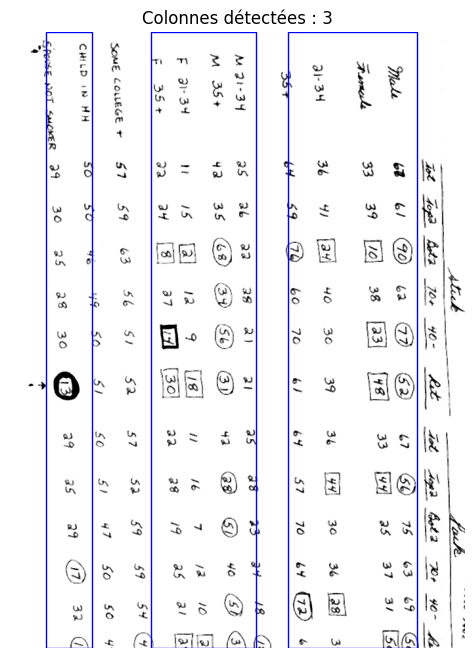

nombre de colonnes : 3


[(54, 124), (214, 375), (424, 620)]

In [16]:
file_path = file_paths.iloc[5]
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
# 2. Détection des marges
top, bottom, left, right = marges(img)  # marges est ta fonction
# 3. Recadrer l'image selon les marges
cropped = img[top:bottom, left:right]
#show_original_and_cropped(img, cropped)

#on lave un peu l'image...
img_np = np.array(cropped)
height, width = img_np.shape

#on regarde le contraste
print("Contraste : ", np.std(img_np))

# Filtre médian pour réduire le bruit ponctuel
denoised = cv2.medianBlur(img_np, ksize=3)  # ksize impair, typiquement 3 ou 5

# Floutage gaussien pour lisser avant seuillage
blurred = cv2.GaussianBlur(denoised, (3,3), 0)

lines = show_detection_nb_lignes(blurred, show=False)
print("nombre de lignes :", len(lines))

colonnes = show_detection_nb_colonnes(denoised, show=True)
print("nombre de colonnes :", len(colonnes))
colonnes

## 5. Extraction sur toutes les images et création d'un .parquet

In [21]:
def get_image_data(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    try:
        Nettete = nettete(img)
        Bruit = bruit(img)
        Ratio_b = ratio_b(img)
        Ratio_n = ratio_n(img)
        Entropie = entropy(img)
        top, bottom, left, right = marges(img)
        # Recadrer l'image selon les marges
        cropped = img[top:bottom, left:right]
        img_np = np.array(cropped)
        height, width = img_np.shape
        # Filtre médian pour réduire le bruit ponctuel
        denoised = cv2.medianBlur(img_np, ksize=3)  # ksize impair, typiquement 3 ou 5
        # Floutage gaussien pour lisser
        blurred = cv2.GaussianBlur(denoised, (3,3), 0)
        lines = show_detection_nb_lignes(blurred, show=False)
        nb_lignes = len(lines)
        colonnes = show_detection_nb_colonnes(denoised, show=False)
        nb_colonnes = len(colonnes)
        with Image.open(file_path) as img:
            Compression = compression(img)[1]
            #Resolution_x = resolution(img)[0] #fixé à 72 lors du preprocessing, valeur standard de rendu écran
            #Resolution_y = resolution(img)[1] #fixé à 72 lors du preprocessing, valeur standard de rendu écran
            #format_ = img.format #toujours des tiff, donc je ne le récupere pas 
            width = img.size[0] 
            #length = img.size[1]#length fixee à 1000 donc je ne la recupere pas 
            #mode = img.mode #toujours L donc je ne le récupere pas 
    except (UnidentifiedImageError, FileNotFoundError, OSError):
        Nettete = Bruit = Ratio_b = Ratio_n = Entropie = Compression = width  = top = bottom = left = right = nb_lignes = nb_colonnes  = np.nan
    return Nettete, Bruit, Ratio_b, Ratio_n, Entropie, Compression, width, top , bottom , left , right , nb_lignes , nb_colonnes


def get_image_data_to_df(serie):
    return pd.DataFrame(
        serie.apply(get_image_data).tolist(),
        columns = ["Nettete", "Bruit", "Ratio_b", "Ratio_n", "Entropie", "Compression", "width", 
                   "top_marge", "bottom_marge", "left_marge", "right_marge", "nb_lignes", "nb_colonnes"],
        index = serie.index
    )

In [27]:
t = time.time()
get_image_data_to_df(file_paths[:100])
print((time.time()-t)*4000/3600)

2.6638346248202853


In [ ]:
#Bon la parallélisation ne fonctionne pas donc, pour le moment, je lance sans paralléliser
# Normalement, ça devrait tourner 16h, mais pas beaucoup plus, sinon, il y a un souci...

t0 = time.time()
df_results = get_image_data_to_df(df)
df = pd.concat([df, df_results], axis=1)
print(f"Durée d'exécution: {time.time() - t0:.2f} secondes pour {len(df)} images")

In [ ]:
df

In [ ]:
df=df.drop(columns=['path', 'relative_path', 'filename'])
df.to_parquet(os.path.join(PATHS.metadata, "df_features.parquet"), index=False)